In [1]:
from fastai.vision.all import *
from fastai.vision.gan import *

In [2]:
path = untar_data(URLs.PETS) 
path_hr = path/'images'
path_lr = path/'crappy'

In [3]:
Path.BASE_PATH = path

In [99]:
import gc

In [103]:
gen_learner_norm = None
learn_critic = None

In [121]:
gc.collect()

17

# Crappified Data

In [4]:
from PIL import Image, ImageDraw, ImageFont

In [5]:
items = get_image_files(path_hr)

In [6]:
item_zero = items[0]
item_zero

Path('images/Birman_115.jpg')

In [7]:
type(item_zero)

pathlib.PosixPath

(500, 358)

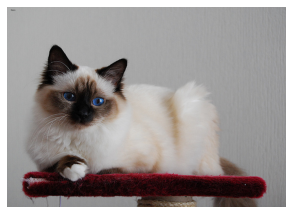

In [8]:
img_zero = PILImage.create(item_zero)
img_zero.show();
img_zero.size

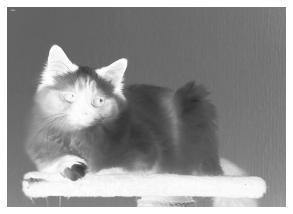

In [9]:
img_zeroBW = PILImageBW.create(item_zero)
img_zeroBW.show();

In [10]:
item_zero.relative_to(path_hr)

Path('Birman_115.jpg')

In [11]:
resize_to(img_zero, 96, use_min=True)

(134, 96)

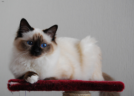

In [12]:
img_zero.resize((134,96), resample=Image.BILINEAR)

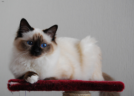

In [13]:
img_zero.resize((134,96), resample=Image.BILINEAR).convert('RGB')

In [14]:
draw = ImageDraw.Draw(img_zero)

In [15]:
#draw.text()

In [16]:
class Crappifier():
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr
        
    def __call__(self, fn):
        dest = self.path_lr/fn.relative_to(self.path_hr)
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PILImage.create(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2), random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

In [17]:
#parallel(Crappifier(path_lr, path_hr), items);

In [5]:
path_hr.ls()

(#7393) [Path('images/Birman_115.jpg'),Path('images/leonberger_142.jpg'),Path('images/Bombay_68.jpg'),Path('images/japanese_chin_26.jpg'),Path('images/saint_bernard_149.jpg'),Path('images/Ragdoll_41.jpg'),Path('images/japanese_chin_32.jpg'),Path('images/Ragdoll_68.jpg'),Path('images/Persian_202.jpg'),Path('images/scottish_terrier_143.jpg')...]

In [6]:
path_lr.ls()

(#7390) [Path('crappy/Birman_115.jpg'),Path('crappy/leonberger_142.jpg'),Path('crappy/Bombay_68.jpg'),Path('crappy/japanese_chin_26.jpg'),Path('crappy/saint_bernard_149.jpg'),Path('crappy/Ragdoll_41.jpg'),Path('crappy/japanese_chin_32.jpg'),Path('crappy/Ragdoll_68.jpg'),Path('crappy/Persian_202.jpg'),Path('crappy/scottish_terrier_143.jpg')...]

In [20]:
crap = get_image_files(path_lr)

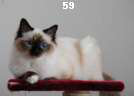

In [21]:
PILImage.create(crap[0])

# Pre-train generator

In [4]:
bs, size = 16, 128
wd = 1e-3
y_range = (-3.,3.)
loss_gen = MSELossFlat()

In [10]:
def get_dls(bs, size):
    dblock = DataBlock(
        blocks=(ImageBlock, ImageBlock),
        get_items = get_image_files,
        get_y = lambda x: path_hr/x.name,
        splitter = RandomSplitter(),
        item_tfms = Resize(size),
        batch_tfms = [*aug_transforms(max_zoom=2.)]
    )
    dls = dblock.dataloaders(path_lr, bs=bs, path=path)
    dls.c = 3
    return dls

In [24]:
dls_gen = get_dls(bs, size)

In [25]:
dls_gen.c

3

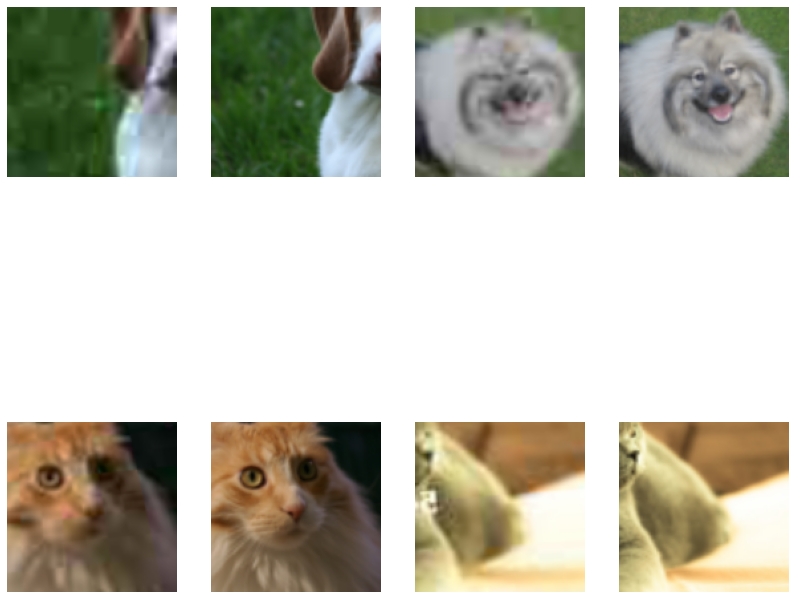

In [26]:
dls_gen.show_batch(max_n=4, figsize=(14,14))

In [30]:
def create_gen_learner():
    return unet_learner(dls_gen, resnet34, loss_func=loss_gen, blur=True, norm_type=NormType.Weight, self_attention=True, y_range=y_range)

In [31]:
learn_gen = create_gen_learner()

In [32]:
learn_gen.fit_one_cycle(2, pct_start=0.8, wd=wd)

epoch,train_loss,valid_loss,time
0,0.044197,0.043316,02:05
1,0.035755,0.036808,02:04


In [33]:
learn_gen.unfreeze()

In [34]:
learn_gen.fit_one_cycle(3, slice(1e-6, 1e-3), wd=wd)

epoch,train_loss,valid_loss,time
0,0.035843,0.036729,02:37
1,0.035133,0.034898,02:37
2,0.034002,0.033996,02:37


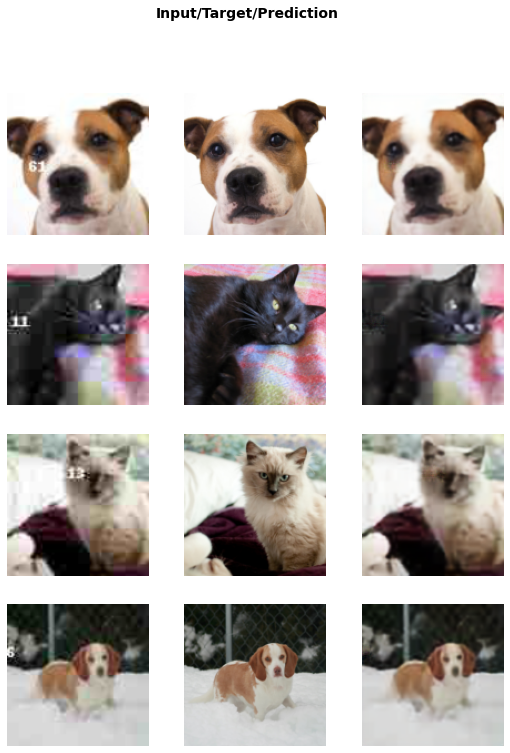

In [35]:
learn_gen.show_results(max_n=4)

In [36]:
learn_gen.save('gen-pre2')

Path('models/gen-pre2.pth')

In [5]:
def get_dls_normalized(bs, size):
    dblock = DataBlock(
        blocks=(ImageBlock, ImageBlock),
        get_items = get_image_files,
        get_y = lambda x: path_hr/x.name,
        splitter = RandomSplitter(),
        item_tfms = Resize(size),
        #batch_tfms = [*aug_transforms(max_zoom=2.), Normalize.from_stats(*imagenet_stats)]
        batch_tfms = []
    )
    dls = dblock.dataloaders(path_lr, bs=bs, path=path)
    dls.c = 3
    return dls

In [6]:
dls_gen_norm = get_dls_normalized(bs, size)

In [7]:
dls_gen_norm.c

3

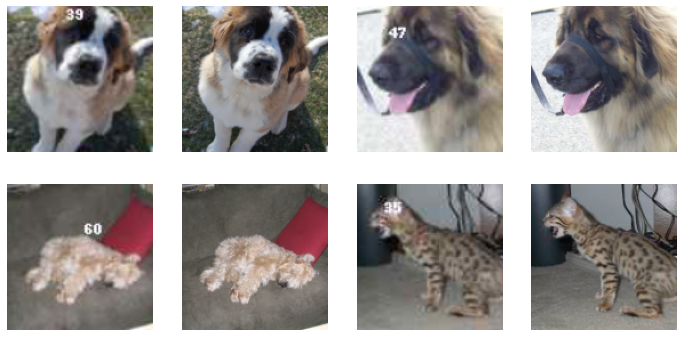

In [8]:
dls_gen_norm.show_batch(max_n=4)

In [9]:
arch = partial(resnet34, pretrained=True)

In [10]:
def create_gen_learner_norm():
    return unet_learner(dls_gen_norm, arch, loss_func=loss_gen, blur=True, norm_type=NormType.Weight, self_attention=True, y_range=y_range)

In [11]:
gen_learner_norm = create_gen_learner_norm()

In [34]:
import gc

In [60]:
learner_gen = None
dls_gen = None

In [37]:
gc.collect()

38

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=2.0892961401841603e-05)

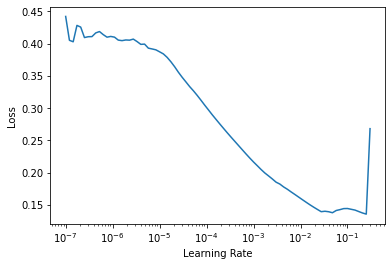

In [17]:
gen_learner_norm.lr_find()

In [18]:
gen_learner_norm.fit_one_cycle(2, pct_start=0.8, wd=wd) # now without any batch_tfms and pretrained resnet34 the loss is suddenly 10x as good!!???
                                                        # is that super convergenge or mistake? pictures look good but eyes are not great +
                                                        # number artifacts

epoch,train_loss,valid_loss,time
0,0.003871,0.002894,03:19
1,0.002265,0.002109,03:07


SuggestedLRs(lr_min=8.31763736641733e-07, lr_steep=6.309573450380412e-07)

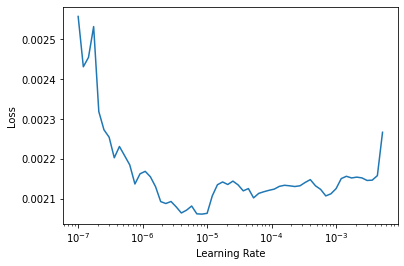

In [19]:
gen_learner_norm.lr_find() # stopped after the first 2 epochs

In [20]:
gen_learner_norm.unfreeze()

SuggestedLRs(lr_min=1.2022644114040304e-06, lr_steep=2.75422871709452e-06)

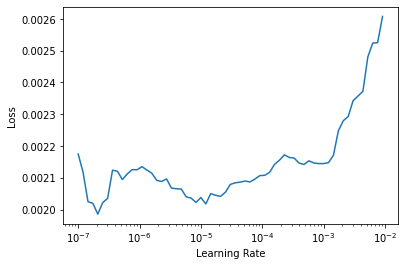

In [21]:
gen_learner_norm.lr_find() # stopped after the first 2 epochs

In [16]:
gen_learner_norm.fit_one_cycle(3, slice(1e-6,1e-3), wd=wd)

epoch,train_loss,valid_loss,time
0,0.037188,0.037482,02:27
1,0.034565,0.035237,02:29
2,0.033376,0.034172,02:29


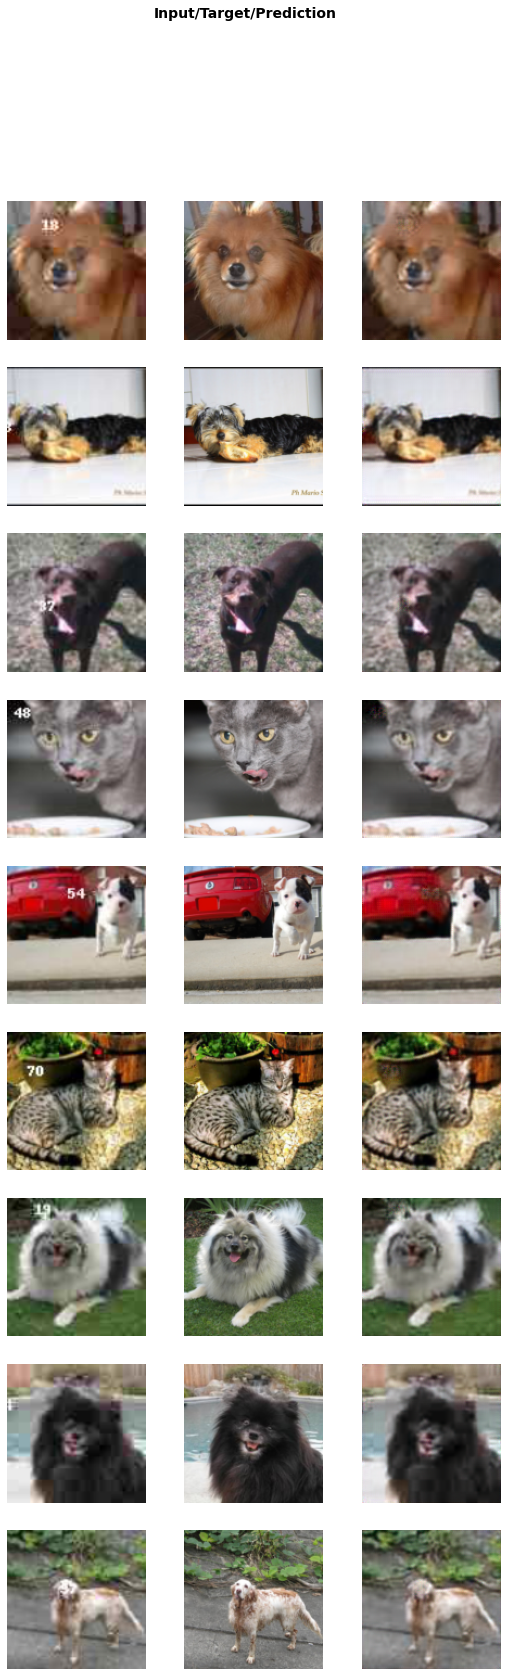

In [22]:
gen_learner_norm.show_results(max_n=9)

In [24]:
#gen_learner_norm.save('gen-pre2-norm')

# Save generated images

In [12]:
gen_learner_norm.load('gen-pre2-norm');

In [13]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [85]:
#shutil.rmtree(path_gen)

In [86]:
path_gen.mkdir(exist_ok=True)

In [87]:
def save_preds(dl, learn):
    names = dl.dataset.items
    
    preds,_ = learn.get_preds(dl=dl)
    for i,pred in enumerate(preds):
        dec = dl.after_batch.decode(TensorImage(pred[None]))[0]
        arr = dec.numpy().transpose(1,2,0)
        Image.fromarray(np.uint8(arr), mode='RGB').save(path_gen/names[i].name)

In [88]:
#dl = dls_gen_norm.train.new(shuffle=False, drop_last=False, after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])
dl = dls_gen_norm.train.new(shuffle=False, drop_last=False, after_batch=[IntToFloatTensor])

In [89]:
save_preds(dl, gen_learner_norm)

In [14]:
path_gen.ls()

(#5912) [Path('image_gen/Bombay_68.jpg'),Path('image_gen/japanese_chin_26.jpg'),Path('image_gen/saint_bernard_149.jpg'),Path('image_gen/Ragdoll_41.jpg'),Path('image_gen/japanese_chin_32.jpg'),Path('image_gen/Ragdoll_68.jpg'),Path('image_gen/Persian_202.jpg'),Path('image_gen/Bombay_215.jpg'),Path('image_gen/havanese_80.jpg'),Path('image_gen/Bengal_69.jpg')...]

In [91]:
generated = get_image_files(path_gen)

In [29]:
preds,_ = gen_learner_norm.get_preds()

In [32]:
pred = preds[0]

In [31]:
dl_gen = gen_learner_norm.dl;

In [45]:
dec = dl_gen.after_batch.decode(TensorImage(pred[None]))[0]

In [46]:
dec.shape

torch.Size([3, 128, 128])

In [50]:
type(dec)

fastai.torch_core.TensorImage

In [52]:
arr = dec.numpy().transpose(1,2,0)
arr.shape

(128, 128, 3)

In [82]:
arr[0][0]

array([76, 76, 71])

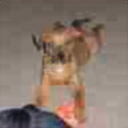

In [85]:
Image.fromarray(np.uint8(arr), mode='RGB')

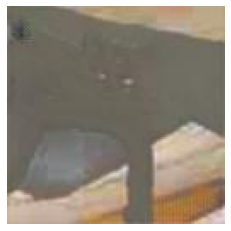

In [34]:
PILImage.create(generated[0]).show();


# Train critic

In [15]:
def get_crit_dls(bs,size):
    crit_dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items = partial(get_image_files, folders=['images', name_gen]),
        get_y = parent_label,
        splitter= RandomSplitter(0.1, seed=42),
        item_tfms = Resize(size),
        batch_tfms = [Normalize.from_stats(*imagenet_stats)]
    )
    return crit_dblock.dataloaders(path, bs=bs, path=path)

In [16]:
dls_crit = get_crit_dls(bs, size)

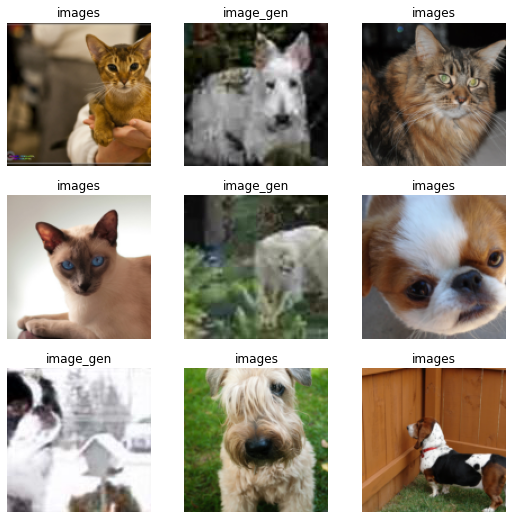

In [17]:
dls_crit.show_batch()

In [18]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [19]:
def create_critic_learner(dls, metrics):
    return Learner(dls, gan_critic(), metrics=metrics, loss_func=loss_critic)

In [20]:
learn_critic = create_critic_learner(dls_crit, accuracy_thresh_expand)

SuggestedLRs(lr_min=5.248074739938602e-06, lr_steep=0.05754399299621582)

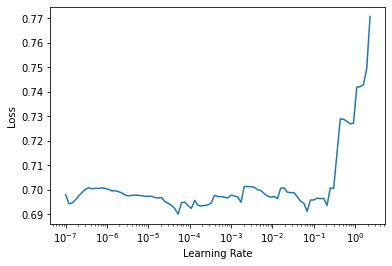

In [122]:
learn_critic.lr_find()

In [21]:
learn_critic.fit_one_cycle(3, 1e-1, wd=wd)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.693684,0.690365,0.559398,04:53
1,0.690002,0.688564,0.559398,05:00
2,0.685443,0.687141,0.559398,05:00


SuggestedLRs(lr_min=3.7153522134758533e-05, lr_steep=0.19952623546123505)

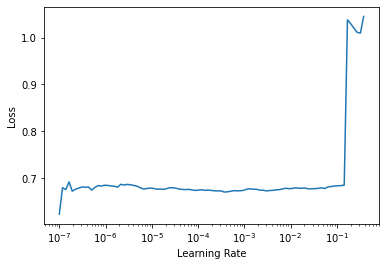

In [125]:
learn_critic.lr_find(end_lr=1)